In [1]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import joblib
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential, Model
from keras.layers import (MaxPooling2D, Dense, Flatten, 
                          Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, accuracy_score)
# Base Libraries
from tensorflow.keras.applications import  VGG19
from tensorflow.keras.models import Model
import numpy as np 
import pandas as pd
import os

from sklearn.model_selection import train_test_split



# Preparing Data to train classifier

In [100]:
# Function to categorize values
def categorize_value(value):
    if value > 0:
        return 'Worsened'
    elif value < 0:
        return 'Improved'
    else:
        return 'No change'


def label_pairs_by_name(pairs_by_name_csv, feature_vector_csv = 'vgg19_feature_severity.csv', plot = False, image_path = "dermnet/train/Psoriasis pictures Lichen Planus and related diseases/"):
    '''
    Input: 
    1. pairs_by_name_csv: output from the pairing_by_names.ipynb
    2. image_path: folder containing dermnet images 
    3. plot (Boolean): plot = True outputs the boxplot showing severity of ImageA and ImageB
    4. feature_vector_csv: VGG19 feature vector csv containing columns of id, severity, and features

    Output:
    1. pairs_by_name: dataframe containing the original pairs_by_name dataframe, with new columns ('SeverityB - SeverityA', 
    'Progression', 'ImageA_path', 'ImageB_path', 'ImageA_index','ImageB_index')
    2. feature_difference: difference in feature vector of ImageB - ImageA

    '''
    pairs_by_name = pd.read_csv(pairs_by_name_csv)

    pairs_by_name['SeverityB - SeverityA'] = pairs_by_name['SeverityB'] - pairs_by_name['SeverityA']

    # Apply the function to create a new categorical column
    pairs_by_name['Progression'] = pairs_by_name['SeverityB - SeverityA'].apply(categorize_value)

    # add image path to image name
    pairs_by_name['ImageA_path'] = image_path + pairs_by_name['ImageA']
    pairs_by_name['ImageB_path'] = image_path + pairs_by_name['ImageB']

    # add image index to pairs_by_name
    train = pd.read_csv('psoriasis_label.csv')
    train['index'] = train.index
    index_image_dict = train.set_index('index')['id'].to_dict() # convert index and image id to a dictionary
    
    pairs_by_name['ImageA_index'] = pairs_by_name['ImageA'].map({v: k for k, v in index_image_dict.items()})
    pairs_by_name['ImageB_index'] = pairs_by_name['ImageB'].map({v: k for k, v in index_image_dict.items()})
    
    print(pairs_by_name.shape)

    # Create plot to show change in severity within the pairs
    if plot == True:
        # Create paired box plots
        bp = plt.boxplot([pairs_by_name['SeverityA'], pairs_by_name['SeverityB']], positions=[0, 1], labels=['SeverityA', 'SeverityB'])

        # Draw lines connecting paired dots with different colors based on the relationship
        for i, row in pairs_by_name.iterrows():
            color = 'green'  # default color for equal values
            if row['SeverityB'] > row['SeverityA']:
                color = 'blue'  # blue for SeverityB > SeverityA
            elif row['SeverityB'] < row['SeverityA']:
                color = 'red'  # red for SeverityB < SeverityA
            plt.plot([0, 1], [row['SeverityA'], row['SeverityB']], color=color, linestyle='--', marker='o')

        # Customize plot
        plt.xlabel('Paired Images')
        plt.ylabel('Severity')
        plt.title('Change in severity for each image pair')
        plt.grid(True)

        # Show plot
        plt.show()

    # Create feature difference betweeen Image B & A
    feature = pd.read_csv(feature_vector_csv,index_col=0)
    feature = np.array(feature.iloc[:, 2:])

    # feature difference in all the pairs 
    ImageA_feature = feature[pairs_by_name['ImageA_index']]
    ImageB_feature = feature[pairs_by_name['ImageB_index']]
    feature_difference = ImageB_feature - ImageA_feature
    print(feature_difference.shape)

    return pairs_by_name, feature_difference


In [101]:
[pairs_by_name, feature_diff_pairs_by_name] = label_pairs_by_name('pairs_by_name.csv')
pairs_by_name.to_csv('pairs_by_name_labelled.csv')

[pairs_by_name_train, feature_diff_pairs_by_name_train] = label_pairs_by_name('pairs_by_name_train.csv')
pairs_by_name_train.to_csv('pairs_by_name_train_labelled.csv')

[pairs_by_name_test, feature_diff_pairs_by_name_test] = label_pairs_by_name('pairs_by_name_test.csv')
pairs_by_name_test.to_csv('pairs_by_name_test_labelled.csv')

(4324, 10)
(4324, 12800)
(1871, 10)
(1871, 12800)
(439, 10)
(439, 12800)


In [103]:
joblib.dump((feature_diff_pairs_by_name, pairs_by_name),'dermnet_X_y_paired_by_name.pkl')
joblib.dump((feature_diff_pairs_by_name_train, pairs_by_name_train),'dermnet_X_y_paired_by_name_train.pkl')
joblib.dump((feature_diff_pairs_by_name_test, pairs_by_name_test),'dermnet_X_y_paired_by_name_test.pkl')

['dermnet_X_y_paired_by_name_test.pkl']

# Training Classifier

In [42]:
CID = 0

In [60]:
X_train, X_test, y_train, y_test = train_test_split(feature_diff_pairs_by_name, pairs_by_name['Progression'], test_size=0.20, random_state=CID)
y_train_cat = y_train
y_test_cat = y_test

In [104]:
def conf_matrix_heatmap(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True,  fmt='d', ax=ax, cmap='Greens'); #annot=True to annotate cells
    ax.set_xlabel('Predicted status')
    ax.set_ylabel('True status')
    ax.set_title('Confusion Matrix')

def modelPerformance(confMat):
    TN = confMat[0, 0]
    TP = confMat[1, 1]
    FP = confMat[0, 1]
    FN = confMat[1, 0]
    prec = TP / (TP + FP)
    rec = TP / (TP + FN)
    spec = TN / (TN + FP)
    fpr = FP / (TN + FP)
    f1 = 2 * (prec * rec) / (prec + rec)
    acc = (TP + TN) / (TP + FP + TN + FN)
    return (acc, prec, rec, spec, fpr, f1)

def printPerformance(confMat):
    acc, prec, rec, spec, fpr, f1 = modelPerformance(confMat)
    print("Accuracy = " "%.4f" % acc)
    print("Precision = " "%.4f" % prec)
    print("Recall = " "%.4f" % rec)
    print("Specificity = " "%.4f" % spec)
    print("False positive rate = " "%.4f" % fpr)
    print("F1-score = " "%.4f" % f1)
    #np.set_printoptions(precision=2)
    np.set_printoptions(suppress=True) # stop scientific notation
    print("Confusion matrix (%):")
    print(confMat/np.sum(confMat)*100)


In [47]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as mx

from sklearn.preprocessing import StandardScaler, scale, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet # for Lasso and Elastic Net logistic regression
# from sklearn.cross_decomposition import PLSRegression # for PLS
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, classification_report
pd.set_option('display.max_colwidth', None)

The scikit-learn version is 1.3.0.


              precision    recall  f1-score   support

    Improved       0.83      0.90      0.86       377
   No change       0.60      0.09      0.15       102
    Worsened       0.81      0.92      0.86       386

    accuracy                           0.82       865
   macro avg       0.75      0.64      0.63       865
weighted avg       0.79      0.82      0.78       865

accuracy: 0.815028901734104


Progression
Worsened     386
Improved     377
No change    102
Name: count, dtype: int64

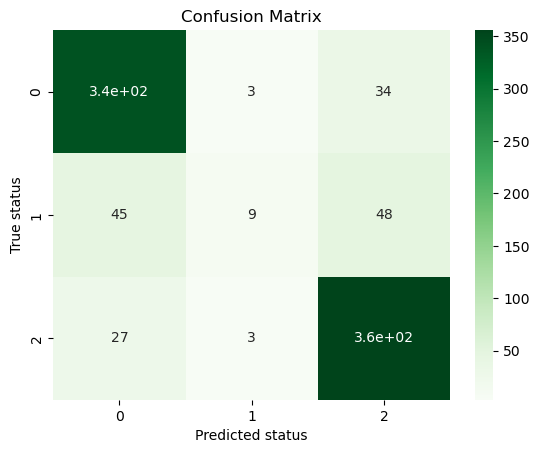

In [52]:
# define the classifier with default parameters
rf_default = RandomForestClassifier(random_state=CID)
y_pred_default = rf_default.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred_default))
print('accuracy:', accuracy_score(y_test, y_pred_default))

cm_default = confusion_matrix(y_test, y_pred_default)
conf_matrix_heatmap(cm_default)
display(y_test.value_counts()) # to see the class breakdown in the test-set 

In [53]:
rf = RandomForestClassifier(
    n_estimators=1000, 
    criterion='entropy', 
    oob_score=True, 
    class_weight='balanced',
    random_state=CID
)
y_pred = rf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))
print('accuracy:', accuracy_score(y_test, y_pred)) # if you want to look at extra decimals
print('oob score:', rf.oob_score_)
cm_default = confusion_matrix(y_test, y_pred)
conf_matrix_heatmap(cm_default)

              precision    recall  f1-score   support

    Improved       0.84      0.92      0.88       377
   No change       0.71      0.12      0.20       102
    Worsened       0.83      0.93      0.87       386

    accuracy                           0.83       865
   macro avg       0.79      0.66      0.65       865
weighted avg       0.82      0.83      0.80       865

accuracy: 0.8289017341040462
oob score: 0.8054350968488002


In [73]:
joblib.dump(rf, 'rf_trained_on_pair_by_name.pkl')

['rf_trained_on_pair_by_name.pkl']

### Train on robustly split train-test 

In [107]:
X_train = feature_diff_pairs_by_name_train
y_train = pairs_by_name_train['Progression']
X_test = feature_diff_pairs_by_name_test
y_test = pairs_by_name_test['Progression']

              precision    recall  f1-score   support

    Improved       0.55      0.55      0.55       201
   No change       0.67      0.03      0.06        59
    Worsened       0.48      0.64      0.55       179

    accuracy                           0.51       439
   macro avg       0.57      0.41      0.39       439
weighted avg       0.54      0.51      0.48       439

accuracy: 0.5148063781321185
oob score: 0.8107963655799038


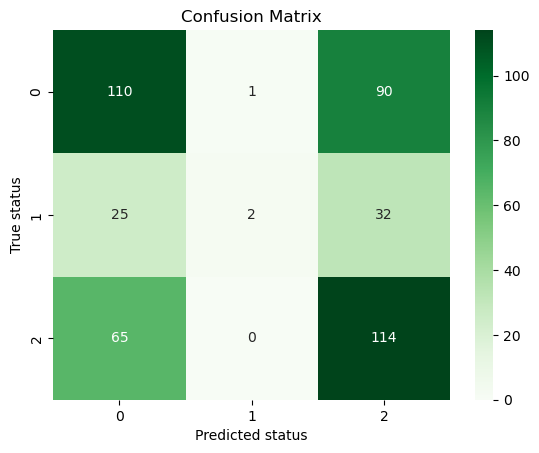

In [108]:
rf = RandomForestClassifier(
    n_estimators=1000, 
    criterion='entropy', 
    oob_score=True, 
    class_weight='balanced',
    random_state=CID
)
y_pred = rf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))
print('accuracy:', accuracy_score(y_test, y_pred)) # if you want to look at extra decimals
print('oob score:', rf.oob_score_)
cm_default = confusion_matrix(y_test, y_pred)
conf_matrix_heatmap(cm_default)

[0.80635838 0.79190751 0.77312139 0.78179191 0.7959479 ]
              precision    recall  f1-score   support

    Improved       0.92      0.84      0.88       411
   No change       0.10      0.67      0.17        15
    Worsened       0.94      0.82      0.88       439

    accuracy                           0.83       865
   macro avg       0.65      0.78      0.64       865
weighted avg       0.91      0.83      0.86       865



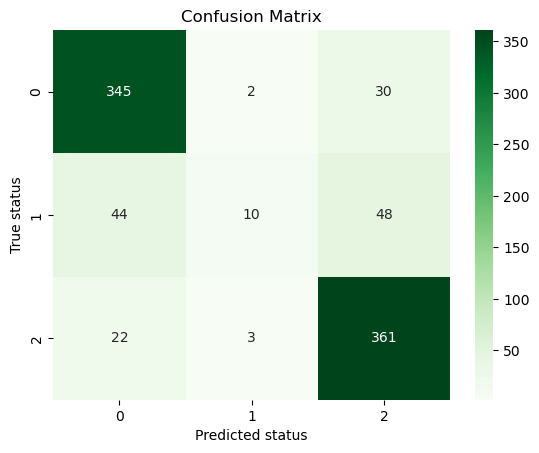

In [55]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Average CV score on the training set was: 0.8107226107226108
Pipeline_RFE_RF = make_pipeline(
    RFE(estimator=ExtraTreesClassifier(criterion="gini", max_features=0.8, n_estimators=100), step=0.2),
    RandomForestClassifier(
        n_estimators=1000, 
        criterion='entropy', 
        oob_score=True, 
        class_weight='balanced',
        random_state=CID)
)


Pipeline_RFE_RF.fit(X_train, y_train)
print(cross_val_score(Pipeline_RFE_RF, X_train, y_train, n_jobs=-1, cv=5)) 

y_val_RFE_RF = Pipeline_RFE_RF.predict(X_test) 
   
# classification report 
print(classification_report(y_val_RFE_RF, y_test)) 
cm_default = confusion_matrix(y_test, y_val_RFE_RF)
conf_matrix_heatmap(cm_default)

## Predict difference (regression)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(Feature_difference, pairs_by_name['SeverityB - SeverityA'], test_size=0.20, random_state=CID)
# Normalize Data

# Instantiate scaler model
scaler = StandardScaler()

# Fit and Transform X_train
X_train_scaled = scaler.fit_transform(X_train)

# Transform X_test
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'standard_scaler_fit_on_Dermnet_train.pkl')

['standard_scaler_fit_on_Dermnet_train.pkl']

In [114]:
# This is just a helper function to get the smape metric - no need to change 
def smape(A, F):
    out =  100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return(out)

## Here we will define several helper functions to compute these metrics 
def RegmodelPerformance(y_true, y_pred):
    exp_var = metrics.explained_variance_score(y_true, y_pred)
    r_square = metrics.r2_score(y_true, y_pred)
    MSE = metrics.mean_squared_error(y_true, y_pred)
    MAE = metrics.mean_absolute_error(y_true, y_pred)
    SMAPE = smape(np.array(y_true), y_pred)
    return(exp_var, r_square, MSE, MAE, SMAPE)

def regression_plot(y_true, y_pred):
        # Calculate R^2 value
    r2 = metrics.r2_score(y_true, y_pred) 

    # Plotting
    plt.scatter(y_true, y_pred)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red', label='perfect model')
    plt.title(f'Actual vs. Predicted with R^2 = {r2:.2f}')
    plt.xlabel('Actual Severity Difference')
    plt.ylabel('Predicted Severity Difference')
    plt.legend()
    plt.show()

def printPerformance(y_true, y_pred):
    exp_var, r_square, MSE, MAE, SMAPE = RegmodelPerformance(y_true, y_pred)
    print("explained variance score = " "%.4f" % exp_var)
    print("R2 = " "%.4f" % r_square)
    print("MSE = " "%.4f" % MSE)
    print("MAE = " "%.4f" % MAE)
    print("SMAPE = " "%.4f" % SMAPE)
    np.set_printoptions(precision=2)
    regression_plot(y_true, y_pred)
    metric = np.array([exp_var, r_square, MSE, MAE, SMAPE])
    return(metric)

In [58]:
# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=20, n_repeats=3, random_state=CID)
# define grid
grid = dict()
grid['alpha'] = np.arange(0.00, 0.041, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# standard scaled 
# perform the search
results = search.fit(X_train_scaled, y_train)
# summarize
print('MAE: %.3f' % (results.best_score_*-1))
print('Config: %s' % results.best_params_)

/Users/kexinxu/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MAE: 0.349
Config: {'alpha': 0.03}


Lasso metrics: 
explained variance score = 0.9794
R2 = 0.9794
MSE = 0.1960
MAE = 0.3243
SMAPE = 39.2942


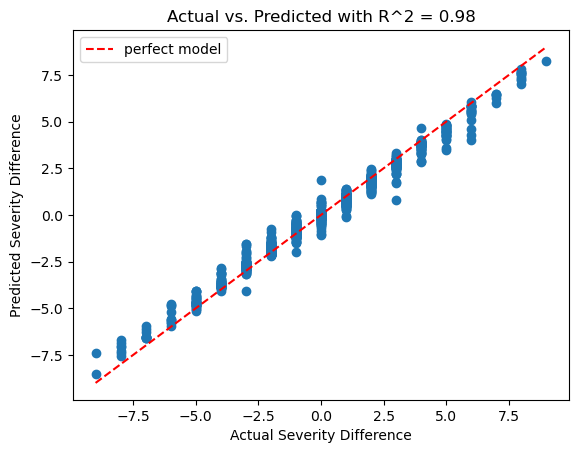

array([ 0.98,  0.98,  0.2 ,  0.32, 39.29])

In [69]:
print("Lasso metrics: ")
y_pred = search.predict(X_test_scaled)
printPerformance(y_test, y_pred)

              precision    recall  f1-score   support

    Improved       0.98      0.96      0.97       377
   No change       0.77      0.86      0.81       102
    Worsened       0.98      0.97      0.98       386

    accuracy                           0.95       865
   macro avg       0.91      0.93      0.92       865
weighted avg       0.96      0.95      0.95       865

accuracy: 0.9526011560693641


Progression
Worsened     386
Improved     377
No change    102
Name: count, dtype: int64

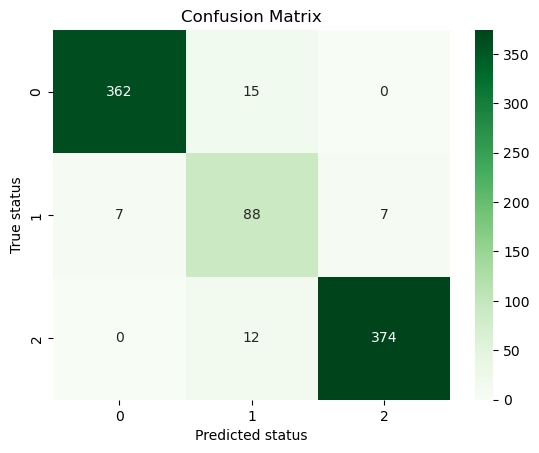

In [65]:
# Convert Lasso result to 3 classes
# Function to categorize values
def categorize_value(value):
    if value > 0.5:
        return 'Worsened'
    elif value < -0.5:
        return 'Improved'
    else:
        return 'No change'

# Apply the function to create a new categorical column
y_pred_lasso_cat = np.vectorize(categorize_value)(y_pred)

print(classification_report(y_test_cat, y_pred_lasso_cat))
print('accuracy:', accuracy_score(y_test_cat, y_pred_lasso_cat))

cm_default = confusion_matrix(y_test_cat, y_pred_lasso_cat)
conf_matrix_heatmap(cm_default)
display(y_test_cat.value_counts()) # to see the class breakdown in the test-set 

In [70]:
joblib.dump(search, 'Lasso_pairs_by_names.pkl')

['Lasso_pairs_by_names.pkl']

### predict difference (regression) on robust train-test-split

In [111]:
X_train = feature_diff_pairs_by_name_train
y_train = pairs_by_name_train['SeverityB - SeverityA']
X_test = feature_diff_pairs_by_name_test
y_test = pairs_by_name_test['SeverityB - SeverityA']

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [112]:
# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=CID)
# define grid
grid = dict()
grid['alpha'] = np.arange(0.00, 0.041, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# standard scaled 
# perform the search
results = search.fit(X_train_scaled, y_train)
# summarize
print('MAE: %.3f' % (results.best_score_*-1))
print('Config: %s' % results.best_params_)

/Users/kexinxu/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/kexinxu/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/kexinxu/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/kexinxu/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/kexinxu/anaconda3

MAE: 0.124
Config: {'alpha': 0.01}


Lasso metrics: 
explained variance score = -34.6875
R2 = -34.7523
MSE = 326.1413
MAE = 6.1075
SMAPE = 146.6910


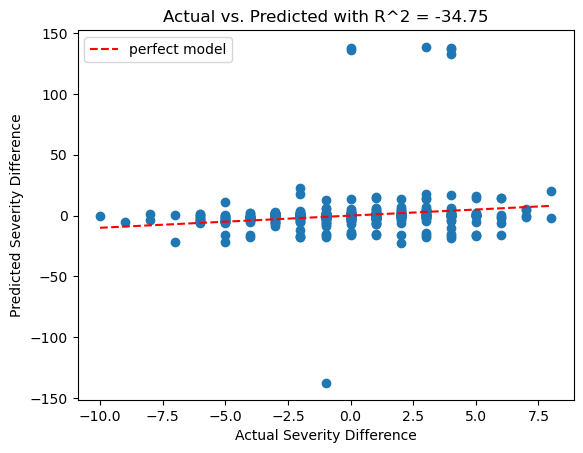

array([-34.69, -34.75, 326.14,   6.11, 146.69])

In [115]:
print("Lasso metrics: ")
y_pred = search.predict(X_test_scaled)
printPerformance(y_test, y_pred)